## Nengo - dl
- NengoDL은 Nengo 모델 용 시뮬레이터. 즉, Nengo 네트워크를 입력으로 사용하고 사용자가 일부 기본 계산을 TensorFlow를 사용하여 해당 네트워크를 시뮬레이션 할 수 있습니다 .
- Nengo나 - Nengo-dl 은 Nengo 구성 코드는 같으며, 변경된 것은 모델을 실행하기 위해 다른 Simulator 클래스를 사용한다는 것

### ■ 장점
- 딥 러닝 학습 방법을 통해 모델의 매개 변수 최적화 (Keras API 사용)
- CPU와 GPU 모두에서 더 빠른 시뮬레이션 속도
- Keras 모델에서 Nengo 네트워크로 자동 변환
- TensorFlow 코드 (개별 기능 또는 전체 네트워크 아키텍처)를 Nengo 모델에 직접 삽입

### ■ Tensorflow 와 Nengo 의 모델 설계시 차이점
- 한 가지 차이점은 Nengo를 사용하면 레이어 생성과 레이어 간의 연결 생성을 분리한다는 것
- 이는 Nengo 네트워크의 연결 구조가 일반적인 딥 러닝 네트워크보다 상태와 일반적인 복잡성이 훨씬 더 많기 때문에 독립적으로 제어 할 수있는 것이 도움이됨
- nengo.Probe. 이것은 시뮬레이션에서 데이터를 수집하는 데 사용됨. 중간에 프로브를 추가하면 시뮬레이션이 실행 중일 때 해당 뉴런의 활동을 수집할 수 있으며 이는 Keras의 Output 으로 나타낼 수 있음

- 또 다른 차이점은 Nengo 입력의 모양에 크기가 1 인 추가 치수. 이것은 시간 차원을 나타냄. 
- **Nengo 시뮬레이션은 본질적으로 시간적**입니다. 
- 그래프가 단순히 추상적 인 계산 집합을 나타내는 TensorFlow와 달리 Nengo에서 우리는 (거의) 항상 그래프를 상태 저장 신경 시뮬레이션을 나타내는 것으로 생각하며, 여기서 값은 시간이 지남에 따라 누적, 업데이트 및 전달됨.

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Simulation finished in 0:00:01                                                 


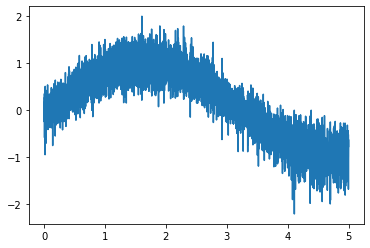

In [5]:
import nengo
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

with nengo.Network() as net:
    # node 
    inp = nengo.Node(output=np.sin)
    ens = nengo.Ensemble(50, 1, neuron_type=nengo.LIF()) # ensemble
    nengo.Connection(inp, ens, synapse=0.1) # connection (node + ensemble)
    p = nengo.Probe(ens)

# tensorflow 기반 데이터
with nengo_dl.Simulator(net) as sim: # this is the only line that changes
    sim.run(5.0)
plt.plot(sim.trange(), sim.data[p])


## Tensorflow 로 간단한 2계층 만들기 

In [ ]:
# baisc library
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# data
n_in = 784 # 28x28
n_hidden = 64
minibatch_size = 50

# input
tf_a = tf.keras.Input(shape=(n_in,))

# first layer - hidden layer
tf_b = tf.keras.layers.Dense(
    n_hidden, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_a)

# second layer - output layer
tf_c = tf.keras.layers.Dense(
    n_in, activation=tf.nn.relu,
    kernel_initializer=tf.initializers.glorot_uniform()
)(tf_b)

In [15]:
# keras 로 실행하기
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
pr = model.predict(np.ones((minibatch_size, n_in)));
pr

array([[0.        , 0.        , 0.26305768, ..., 0.08309107, 0.12972961,
        0.03463218],
       [0.        , 0.        , 0.26305768, ..., 0.08309107, 0.12972961,
        0.03463218],
       [0.        , 0.        , 0.26305768, ..., 0.08309107, 0.12972961,
        0.03463218],
       ...,
       [0.        , 0.        , 0.2630575 , ..., 0.0830911 , 0.12972978,
        0.03463205],
       [0.        , 0.        , 0.2630575 , ..., 0.0830911 , 0.12972978,
        0.03463205],
       [0.        , 0.        , 0.2630575 , ..., 0.0830911 , 0.12972978,
        0.03463205]], dtype=float32)

## Nengo로 간단한 2계층 만들기

In [12]:
# nengo_dl
import nengo_dl
import nengo
from nengo.utils.matplotlib import rasterplot

# data
n_in = 784 # 28x28
n_hidden = 64
minibatch_size = 50

# nengo - Network 만들기
with nengo.Network() as auto_net:
    # input node
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer (input node + ensemble b)
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer (ensemble b + ensemble c)
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=nengo.RectifiedLinear())
    
    nengo.Connection(nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.Glorot())
    
    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

In [18]:
# nengo_dl 을 이용한 predict
with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
    sim.fit(xTRAIN, YTRAIN)
    nengo_pr = sim.predict(np.ones((minibatch_size, 1, n_in)));
    
nengo_pr

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


OrderedDict([(<Probe at 0x217f70f8188 of 'output' of <Neurons of <Ensemble (unlabeled) at 0x217f70c80c8>>>,
              array([[[ 82.74273 ,  21.4258  , 110.13253 , ..., 139.14568 ,
                        82.366806,   0.      ]],
              
                     [[ 82.74273 ,  21.4258  , 110.13253 , ..., 139.14568 ,
                        82.366806,   0.      ]],
              
                     [[ 82.74273 ,  21.4258  , 110.13253 , ..., 139.14568 ,
                        82.366806,   0.      ]],
              
                     ...,
              
                     [[ 82.74273 ,  21.4258  , 110.13253 , ..., 139.14568 ,
                        82.366806,   0.      ]],
              
                     [[ 82.74273 ,  21.4258  , 110.13253 , ..., 139.14568 ,
                        82.366806,   0.      ]],
              
                     [[ 82.74273 ,  21.4258  , 110.13253 , ..., 139.14568 ,
                        82.366806,   0.      ]]], dtype=float32))])